In [1]:
import numpy as np
import pandas as pd
import numpy.matlib
import scipy as sc
import random
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, LabelBinarizer
from sklearn.metrics import accuracy_score
# from lpproj import LocalityPreservingProjection
import matplotlib.pyplot as plt

# from lpproj import LocalityPreservingProjection
from tqdm import tqdm
%matplotlib inline

from utils import *

Using TensorFlow backend.


In [2]:
def set_data(ntrain, ntest, nanc, non_iid='False'):
    
    (Xtrain, ytrain), (Xtest, ytest) = fashion_mnist.load_data()
    ind2 = np.random.choice(10000,ntest,replace=False)
    
    if non_iid == 'False':
        # random choice
        ind1 = np.random.choice(60000,ntrain, replace=False)
    else:
    # line up labels by protions of 50
        ind1= []
        for i in range(10):
            counter = 0
            for j, label in enumerate(ytrain):
                if label == i:
                    ind1.append(j)
                    counter += 1
                if counter >= 50:
                    break
        
    
    if non_iid == 'Kinda':
        ind1 = np.hstack([ind1[25:], ind1[:25]])
    ind1 = ind1[:ntrain]

    
    Xtrain = Xtrain[ind1]
    ytrain = ytrain[ind1]
    Xtest = Xtest[ind2]
    ytest = ytest[ind2]
    
    
    # reshape
    Xtrain = normalize(Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1]*Xtrain.shape[2]))
    Xtest = normalize(Xtest.reshape(Xtest.shape[0], Xtest.shape[1]*Xtest.shape[2]))
    
    
    anc = make_anchors(Xtrain, nanc)
    
    return Xtrain, ytrain, Xtest, ytest, anc

#     if non_iid == 'Kinda':
#         ind1 = []
#         for i in range(10):

#         # non-idd split
#         Div_data = []
#         labels = [i for i in range(np.max(ytrain)+1)]

#         for i in range(ii+1):
#             inds = [i for i, label in enumerate(ytrain) if label == labels[part] or label == labels[part+1]]
#             Div_data.append({'X':Xtrain[inds, :], 'y':ytrain[inds], 'anc':anc,
#                              'Xtest':Xtest, 'ytest':ytest,}) 

In [3]:
def set_anchor(Xtrain, n_anchors):
    Xave = (np.sum(Xtrain, 1) / np.size(Xtrain,1)).reshape(Xtrain.shape[0],1)
    Xdiv = np.sqrt(np.sum((Xtrain - Xave)**2, 1) / np.size(Xtrain, 1))
    Xcnt = (np.nanmax(Xtrain, axis=1) + np.nanmin(Xtrain, axis=1)) / 2
    Xrad = (np.nanmax(Xtrain, axis=1) - np.nanmin(Xtrain, axis=1)) / 2
    anc = (np.dot(Xcnt.reshape(Xcnt.shape[0], 1), np.ones((1, n_anchors))) 
            + 2 * Xrad.reshape(Xrad.shape[0], 1) * np.random.random((np.size(Xtrain,0), n_anchors)) - 0.5)
    return anc

In [5]:
# parameters
nparts = 5            # number of parties
ndat = 100            # size of data portions
ntest = 1000          # size of test data
ntrain = nparts*ndat  # size of all training data
nanc = 200           # number of anchor data
repeat = 10           # number of repeated experiments
dd=12


acc_cntr = np.zeros([repeat, nparts])
acc_ind = np.zeros([repeat, nparts])
acc_dc = np.zeros([repeat, nparts])

for r in tqdm(range(repeat)):
    random.seed(r)
    for ii in range(nparts):
        ntrain = ii*ndat + ndat
        Xtrain, ytrain, Xtest, ytest, anc = set_data(ntrain, ntest, nanc, non_iid='True')
        print(f'User {ii+1}: {Counter(ytrain[ii*ndat: ii*ndat+ndat])}')

        # pseudo-split of data
        Div_data = []
        for i in range(ii+1):
            start = i*ndat
            stop = i*ndat + ndat
            Div_data.append({'X':Xtrain[start:stop], 'y':ytrain[start:stop], 'anc':anc,
                             'Xtest':Xtest}) 
            

        # Main
        # train classifier on all data

        cntr = knn_cls(Xtrain, Xtest, ytrain, ytest)
        acc_cntr[r, ii] = cntr
        
        if ii == 0:
            # train classifier on data of one user
            ind = cntr
        acc_ind[r, ii] = ind


        # Proposed method
        X_dc, X_test_dc = data_collaboration(Div_data, dd)
        dc = knn_cls(X_dc, X_test_dc, ytrain, ytest)
        acc_dc[r, ii] = dc

knn_cntr = np.around(np.mean(acc_cntr, 0), decimals=2)
knn_ind = np.around(np.mean(acc_ind, 0), decimals=2)
knn_dc = np.around(np.mean(acc_dc, 0), decimals=2)

print('Averaged over {} runs'.format(repeat))
print('Centralized average accuracy:', knn_cntr)
print('Individual average accuracy:', knn_ind)
print('Collaboration average accuracy:', knn_dc)

  0%|          | 0/10 [00:00<?, ?it/s]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 10%|█         | 1/10 [00:03<00:32,  3.61s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 20%|██        | 2/10 [00:07<00:28,  3.58s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 30%|███       | 3/10 [00:10<00:25,  3.59s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 40%|████      | 4/10 [00:14<00:21,  3.61s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 50%|█████     | 5/10 [00:18<00:18,  3.63s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 60%|██████    | 6/10 [00:21<00:14,  3.61s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 70%|███████   | 7/10 [00:25<00:10,  3.60s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 80%|████████  | 8/10 [00:28<00:07,  3.60s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


 90%|█████████ | 9/10 [00:32<00:03,  3.58s/it]

User 1: Counter({0: 50, 1: 50})
User 2: Counter({2: 50, 3: 50})
User 3: Counter({4: 50, 5: 50})
User 4: Counter({6: 50, 7: 50})
User 5: Counter({8: 50, 9: 50})


100%|██████████| 10/10 [00:35<00:00,  3.59s/it]

Averaged over 10 runs
Centralized average accuracy: [0.18 0.35 0.5  0.57 0.74]
Individual average accuracy: [0.18 0.18 0.18 0.18 0.18]
Collaboration average accuracy: [0.18 0.24 0.28 0.27 0.31]


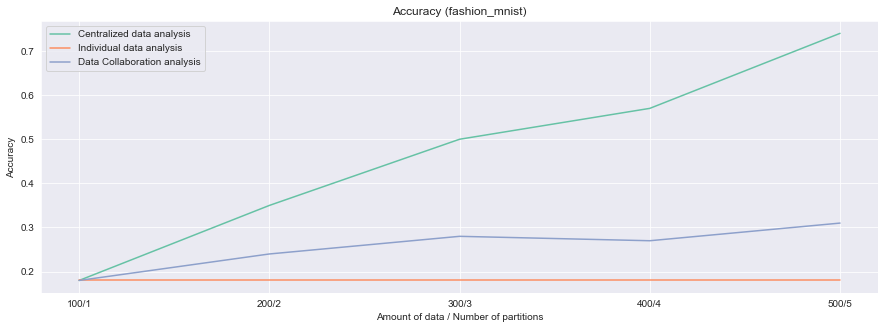

In [6]:
plt.figure(figsize=(15,5))
plt.plot(knn_cntr, label='Centralized data analysis')
plt.plot(knn_ind, label='Individual data analysis')
plt.plot(knn_dc, label='Data Collaboration analysis')
plt.ylabel('Accuracy')
plt.xlabel('Amount of data / Number of partitions')
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 5, step = 1), ('100/1', '200/2', '300/3', '400/4', '500/5'))
plt.title("Accuracy (fashion_mnist)")
plt.legend()

# with Federated Learning

In [7]:
from collections import  Counter
Div_data = []
for i in range(nparts):
    start = i*ndat
    stop = i*ndat + ndat
    Div_data.append({'X':Xtrain[start:stop, :], 'y':ytrain[start:stop], 'anc':anc,
                      'Xtest':Xtest, 'ytest':ytest,})
    print(Counter(ytrain[start:stop]))

Counter({0: 50, 1: 50})
Counter({2: 50, 3: 50})
Counter({4: 50, 5: 50})
Counter({6: 50, 7: 50})
Counter({8: 50, 9: 50})


In [8]:
centralized_model = create_compiled_keras_model(Xtrain.shape[1])
cntr_history_callback =centralized_model.fit(Xtrain, ytrain, validation_data= (Xtest, ytest), batch_size=32, epochs=12) 

Train on 500 samples, validate on 1000 samples
Epoch 1/12
500/500 [==============================] - 1s 1ms/sample - loss: 2.1091 - sparse_categorical_accuracy: 0.3440 - val_loss: 1.7978 - val_sparse_categorical_accuracy: 0.5630
Epoch 2/12
500/500 [==============================] - 0s 205us/sample - loss: 1.5422 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.2483 - val_sparse_categorical_accuracy: 0.6200
Epoch 3/12
500/500 [==============================] - 0s 210us/sample - loss: 1.1494 - sparse_categorical_accuracy: 0.6060 - val_loss: 0.9823 - val_sparse_categorical_accuracy: 0.6570
Epoch 4/12
500/500 [==============================] - 0s 207us/sample - loss: 0.9300 - sparse_categorical_accuracy: 0.6840 - val_loss: 0.8831 - val_sparse_categorical_accuracy: 0.6770
Epoch 5/12
500/500 [==============================] - 0s 208us/sample - loss: 0.7857 - sparse_categorical_accuracy: 0.7320 - val_loss: 0.8057 - val_sparse_categorical_accuracy: 0.6980
Epoch 6/12
500/500 [===============

In [9]:
X_ind, y_ind = Div_data[0]['X'], Div_data[0]['y']
individual_model = create_compiled_keras_model(X_ind.shape[1])
ind_history_callback = individual_model.fit(X_ind, y_ind, validation_data=(Xtest, ytest),
                                            batch_size=32, epochs=12)

Train on 100 samples, validate on 1000 samples
Epoch 1/12
100/100 [==============================] - 0s 3ms/sample - loss: 2.1698 - sparse_categorical_accuracy: 0.5500 - val_loss: 2.3073 - val_sparse_categorical_accuracy: 0.2030
Epoch 2/12
100/100 [==============================] - 0s 547us/sample - loss: 1.5831 - sparse_categorical_accuracy: 0.9300 - val_loss: 2.5104 - val_sparse_categorical_accuracy: 0.2030
Epoch 3/12
100/100 [==============================] - 0s 530us/sample - loss: 0.9483 - sparse_categorical_accuracy: 0.9300 - val_loss: 3.2391 - val_sparse_categorical_accuracy: 0.1990
Epoch 4/12
100/100 [==============================] - 0s 552us/sample - loss: 0.5466 - sparse_categorical_accuracy: 0.8900 - val_loss: 4.3766 - val_sparse_categorical_accuracy: 0.1980
Epoch 5/12
100/100 [==============================] - 0s 543us/sample - loss: 0.3860 - sparse_categorical_accuracy: 0.9200 - val_loss: 5.2942 - val_sparse_categorical_accuracy: 0.2060
Epoch 6/12
100/100 [===============

In [10]:
X_dc, X_test_dc = data_collaboration(Div_data, dd)
dc_model = create_compiled_keras_model(X_dc.shape[1])
dc_history_callback = dc_model.fit(X_dc, ytrain, validation_data=(X_test_dc, ytest),
                                   batch_size=32, epochs=12)

Train on 500 samples, validate on 1000 samples
Epoch 1/12
500/500 [==============================] - 0s 654us/sample - loss: 2.2559 - sparse_categorical_accuracy: 0.3640 - val_loss: 2.2437 - val_sparse_categorical_accuracy: 0.2870
Epoch 2/12
500/500 [==============================] - 0s 103us/sample - loss: 2.0962 - sparse_categorical_accuracy: 0.4820 - val_loss: 2.1518 - val_sparse_categorical_accuracy: 0.3040
Epoch 3/12
500/500 [==============================] - 0s 102us/sample - loss: 1.8261 - sparse_categorical_accuracy: 0.5460 - val_loss: 2.0682 - val_sparse_categorical_accuracy: 0.3980
Epoch 4/12
500/500 [==============================] - 0s 95us/sample - loss: 1.4927 - sparse_categorical_accuracy: 0.6200 - val_loss: 2.0191 - val_sparse_categorical_accuracy: 0.4160
Epoch 5/12
500/500 [==============================] - 0s 107us/sample - loss: 1.2306 - sparse_categorical_accuracy: 0.6700 - val_loss: 2.1078 - val_sparse_categorical_accuracy: 0.4050
Epoch 6/12
500/500 [==============

# Anna-san's method 

In [26]:
initial_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

FedTrain = np.zeros((repeat, 12))
FedTest = np.zeros((repeat, 12))
FedAcc = np.zeros((repeat, 12))

for rr in range(repeat):
    
    for r in range(12):

        deltas = []

        for c in range(nparts):

            federated_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

            federated_model.set_weights(initial_model.get_weights())

            federated_model.fit(Div_data[c]['X'], Div_data[c]['y'], 
                                                   batch_size=32, epochs=3, verbose=0)


            delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

            deltas.append(delta)
        print('Epoch {}/12'.format(r+1))
        delt_av = (deltas[0] + deltas[1] + deltas[2] + deltas[3] + deltas[4]) / 5
        new_weights = np.array(initial_model.get_weights()) - delt_av

        initial_model.set_weights(new_weights)
        
        validation = initial_model.evaluate(Xtest, ytest)
        
        FedTrain[rr, r] = initial_model.evaluate(Xtrain, ytrain)[0]
        FedTest[rr, r] = validation[0]
        FedAcc[rr, r] = validation[1]

FedTrain = np.mean(FedTrain, axis=0)
FedTest = np.mean(FedTest, axis=0)
FedAcc = np.mean(FedAcc, axis=0)

Epoch 1/12
500/500 [==============================] - 0s 46us/sample - loss: 2.2107 - sparse_categorical_accuracy: 0.3240
Epoch 2/12
500/500 [==============================] - 0s 60us/sample - loss: 2.0781 - sparse_categorical_accuracy: 0.3620
Epoch 3/12
500/500 [==============================] - 0s 44us/sample - loss: 1.9325 - sparse_categorical_accuracy: 0.3300
Epoch 4/12
500/500 [==============================] - 0s 59us/sample - loss: 1.8047 - sparse_categorical_accuracy: 0.3660
Epoch 5/12
500/500 [==============================] - 0s 42us/sample - loss: 1.7039 - sparse_categorical_accuracy: 0.4060
Epoch 6/12
500/500 [==============================] - 0s 44us/sample - loss: 1.6244 - sparse_categorical_accuracy: 0.3900
Epoch 7/12
500/500 [==============================] - 0s 53us/sample - loss: 1.5757 - sparse_categorical_accuracy: 0.3880
Epoch 8/12
500/500 [==============================] - 0s 45us/sample - loss: 1.5123 - sparse_categorical_accuracy: 0.4320
Epoch 9/12
500/500 [====

500/500 [==============================] - 0s 66us/sample - loss: 1.0174 - sparse_categorical_accuracy: 0.6180
Epoch 12/12
500/500 [==============================] - 0s 57us/sample - loss: 1.0646 - sparse_categorical_accuracy: 0.5940
Epoch 1/12
500/500 [==============================] - 0s 57us/sample - loss: 1.0209 - sparse_categorical_accuracy: 0.6240
Epoch 2/12
500/500 [==============================] - 0s 47us/sample - loss: 0.9934 - sparse_categorical_accuracy: 0.6320
Epoch 3/12
500/500 [==============================] - 0s 55us/sample - loss: 1.0155 - sparse_categorical_accuracy: 0.6260
Epoch 4/12
500/500 [==============================] - 0s 45us/sample - loss: 0.9845 - sparse_categorical_accuracy: 0.6420
Epoch 5/12
500/500 [==============================] - 0s 52us/sample - loss: 1.0399 - sparse_categorical_accuracy: 0.5900
Epoch 6/12
500/500 [==============================] - 0s 55us/sample - loss: 1.0135 - sparse_categorical_accuracy: 0.6020
Epoch 7/12
500/500 [==============

500/500 [==============================] - 0s 44us/sample - loss: 0.8978 - sparse_categorical_accuracy: 0.6840
Epoch 11/12
500/500 [==============================] - 0s 44us/sample - loss: 0.8836 - sparse_categorical_accuracy: 0.6760
Epoch 12/12
500/500 [==============================] - 0s 46us/sample - loss: 0.8968 - sparse_categorical_accuracy: 0.6540
Epoch 1/12
500/500 [==============================] - 0s 53us/sample - loss: 0.8740 - sparse_categorical_accuracy: 0.6840
Epoch 2/12
500/500 [==============================] - 0s 57us/sample - loss: 0.9005 - sparse_categorical_accuracy: 0.6740
Epoch 3/12
500/500 [==============================] - 0s 57us/sample - loss: 0.8692 - sparse_categorical_accuracy: 0.6720
Epoch 4/12
500/500 [==============================] - 0s 43us/sample - loss: 0.8848 - sparse_categorical_accuracy: 0.6880
Epoch 5/12
500/500 [==============================] - 0s 42us/sample - loss: 0.8596 - sparse_categorical_accuracy: 0.6960
Epoch 6/12
500/500 [=============

500/500 [==============================] - 0s 56us/sample - loss: 0.7791 - sparse_categorical_accuracy: 0.7180
Epoch 9/12
500/500 [==============================] - 0s 55us/sample - loss: 0.8049 - sparse_categorical_accuracy: 0.7000
Epoch 10/12
500/500 [==============================] - 0s 46us/sample - loss: 0.7592 - sparse_categorical_accuracy: 0.7160
Epoch 11/12
500/500 [==============================] - 0s 55us/sample - loss: 0.7519 - sparse_categorical_accuracy: 0.7220
Epoch 12/12
500/500 [==============================] - 0s 54us/sample - loss: 0.7418 - sparse_categorical_accuracy: 0.7340
Epoch 1/12
500/500 [==============================] - 0s 53us/sample - loss: 0.7377 - sparse_categorical_accuracy: 0.7300
Epoch 2/12
500/500 [==============================] - 0s 46us/sample - loss: 0.6830 - sparse_categorical_accuracy: 0.7420
Epoch 3/12
500/500 [==============================] - 0s 53us/sample - loss: 0.6960 - sparse_categorical_accuracy: 0.7400
Epoch 4/12
500/500 [============

In [27]:
# initial_model = create_compiled_keras_model(Div_data_dc[0].shape[1])

# DCFedTrain = []
# DCFedTest = []
# DCFedAcc = []

# for r in range(12):
    
#     deltas = []

#     for c in range(nparts):

#         federated_model = create_compiled_keras_model(Div_data_dc[0].shape[1])

#         federated_model.set_weights(initial_model.get_weights())

#         history_callback = federated_model.fit(Div_data_dc[c], Div_data[c]['y'], 
#                                                batch_size=32, epochs=1, verbose=0)

        
#         delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

#         deltas.append(delta)
#     print('Epoch {}/12'.format(r+1))
#     delt_av = (deltas[0] + deltas[1] + deltas[2] + deltas[3] + deltas[4]) / 5
#     new_weights = np.array(initial_model.get_weights()) - delt_av
#     initial_model.set_weights(new_weights)
    
#     DCFedTrain.append(initial_model.evaluate(X_dc, ytrain)[0])
#     validation = initial_model.evaluate(X_test_dc, ytest)
#     DCFedTest.append(validation[0])
#     DCFedAcc.append(validation[1])

Text(0.5, 1.0, 'Validation Accuracy, NN')

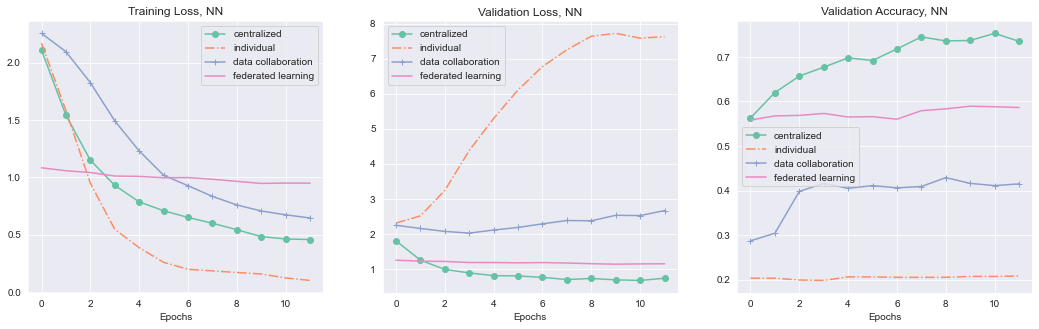

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


ax[0].plot(cntr_history_callback.history['loss'], '-o', label='centralized')
ax[0].plot(ind_history_callback.history['loss'], '-.', label='individual')
ax[0].plot(dc_history_callback.history['loss'], '-+',label='data collaboration')
ax[0].plot(FedTrain, label='federated learning')
# ax[0].plot(DCFedTrain, label='dc federated learning')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[0].set_title('Training Loss, NN')

ax[1].plot(cntr_history_callback.history['val_loss'], '-o',label='centralized')
ax[1].plot(ind_history_callback.history['val_loss'], '-.',label='individual')
ax[1].plot(dc_history_callback.history['val_loss'], '-+', label='data collaboration')
ax[1].plot(FedTest, label='federated learning')
# ax[1].plot(DCFedTest, label='dc federated learning')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[1].set_title('Validation Loss, NN')

ax[2].plot(cntr_history_callback.history['val_sparse_categorical_accuracy'], '-o', label='centralized')
ax[2].plot(ind_history_callback.history['val_sparse_categorical_accuracy'], '-.', label='individual')
ax[2].plot(dc_history_callback.history['val_sparse_categorical_accuracy'], '-+', label='data collaboration')
ax[2].plot(FedAcc, label='federated learning')
# ax[2].plot(DCFedAcc, label='dc federated learning')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[2].set_title('Validation Accuracy, NN')

# Akie's method

reference
- [pytorch](https://github.com/AshwinRJ/Federated-Learning-PyTorch/blob/master/src/utils.py)
- [kears](https://github.com/shaoxiongji/federated-learning/blob/f573d9c7a1c23d8e8360ec347efce2ad9dcd48be/models/Fed.py#L10)


In [24]:
initial_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

FedTrain = np.zeros((repeat, 12))
FedTest = np.zeros((repeat, 12))
FedAcc = np.zeros((repeat, 12))

for rr in range(repeat):
    
    for r in range(12):

        w_list, ndat_list = [], []
        # deltas = []

        for c in range(nparts):

            federated_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

            federated_model.set_weights(initial_model.get_weights())

            federated_model.fit(Div_data[c]['X'], Div_data[c]['y'], 
                                                   batch_size=32, epochs=3, verbose=0)

            w_list.append(federated_model.get_weights())
            ndat_list.append(len(Div_data[c]['X']))

            # delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

            # deltas.append(delta)
        print('Epoch {}/12'.format(r+1))
        # delt_av = (deltas[0] + deltas[1] + deltas[2] + deltas[3] + deltas[4]) / 5
        # new_weights = np.array(initial_model.get_weights()) - delt_av

        total_size = np.sum(ndat_list)
        new_weights = [np.zeros(w.shape) for w in initial_model.get_weights()]
        for w in range(len(new_weights)):
          for c in range(nparts):
            new_weights[w] += w_list[c][w] * ndat_list[c] / total_size

        initial_model.set_weights(new_weights)
        
        
        FedTrain[rr, r] = initial_model.evaluate(Xtrain, ytrain)[0]
        validation = initial_model.evaluate(Xtest, ytest)
        FedTest[rr, r] = validation[0]
        FedAcc[rr, r] = validation[1]

FedTrain = np.mean(FedTrain, axis=0)
FedTest = np.mean(FedTest, axis=0)
FedAcc = np.mean(FedAcc, axis=0)

Epoch 1/12
1000/1000 [==============================] - 0s 49us/sample - loss: 2.1913 - sparse_categorical_accuracy: 0.2050
Epoch 2/12
1000/1000 [==============================] - 0s 61us/sample - loss: 2.0630 - sparse_categorical_accuracy: 0.3410
Epoch 3/12
1000/1000 [==============================] - 0s 52us/sample - loss: 1.9301 - sparse_categorical_accuracy: 0.3210
Epoch 4/12
1000/1000 [==============================] - 0s 45us/sample - loss: 1.8212 - sparse_categorical_accuracy: 0.3140
Epoch 5/12
1000/1000 [==============================] - 0s 47us/sample - loss: 1.7235 - sparse_categorical_accuracy: 0.3470
Epoch 6/12
1000/1000 [==============================] - 0s 50us/sample - loss: 1.6602 - sparse_categorical_accuracy: 0.3500
Epoch 7/12
1000/1000 [==============================] - 0s 58us/sample - loss: 1.6024 - sparse_categorical_accuracy: 0.3640
Epoch 8/12
1000/1000 [==============================] - 0s 48us/sample - loss: 1.5686 - sparse_categorical_accuracy: 0.3610
Epoch 9/

1000/1000 [==============================] - 0s 54us/sample - loss: 1.2290 - sparse_categorical_accuracy: 0.5350
Epoch 12/12
1000/1000 [==============================] - 0s 36us/sample - loss: 1.2572 - sparse_categorical_accuracy: 0.5480
Epoch 1/12
1000/1000 [==============================] - 0s 48us/sample - loss: 1.1811 - sparse_categorical_accuracy: 0.5820
Epoch 2/12
1000/1000 [==============================] - 0s 49us/sample - loss: 1.2195 - sparse_categorical_accuracy: 0.5440
Epoch 3/12
1000/1000 [==============================] - 0s 69us/sample - loss: 1.2243 - sparse_categorical_accuracy: 0.5440
Epoch 4/12
1000/1000 [==============================] - 0s 48us/sample - loss: 1.1710 - sparse_categorical_accuracy: 0.5750
Epoch 5/12
1000/1000 [==============================] - 0s 46us/sample - loss: 1.1816 - sparse_categorical_accuracy: 0.5270
Epoch 6/12
1000/1000 [==============================] - 0s 47us/sample - loss: 1.1620 - sparse_categorical_accuracy: 0.5650
Epoch 7/12
1000/10

1000/1000 [==============================] - 0s 46us/sample - loss: 1.1013 - sparse_categorical_accuracy: 0.6390
Epoch 11/12
1000/1000 [==============================] - 0s 49us/sample - loss: 1.1885 - sparse_categorical_accuracy: 0.5850
Epoch 12/12
1000/1000 [==============================] - 0s 46us/sample - loss: 1.0875 - sparse_categorical_accuracy: 0.6310
Epoch 1/12
1000/1000 [==============================] - 0s 48us/sample - loss: 1.1499 - sparse_categorical_accuracy: 0.6120
Epoch 2/12
1000/1000 [==============================] - 0s 53us/sample - loss: 1.1023 - sparse_categorical_accuracy: 0.6200
Epoch 3/12
1000/1000 [==============================] - 0s 49us/sample - loss: 1.2141 - sparse_categorical_accuracy: 0.6050
Epoch 4/12
1000/1000 [==============================] - 0s 50us/sample - loss: 1.0846 - sparse_categorical_accuracy: 0.6230
Epoch 5/12
1000/1000 [==============================] - 0s 48us/sample - loss: 1.1340 - sparse_categorical_accuracy: 0.6250
Epoch 6/12
1000/1

1000/1000 [==============================] - 0s 47us/sample - loss: 1.0862 - sparse_categorical_accuracy: 0.6440
Epoch 9/12
1000/1000 [==============================] - 0s 47us/sample - loss: 1.1021 - sparse_categorical_accuracy: 0.6570
Epoch 10/12
1000/1000 [==============================] - 0s 49us/sample - loss: 1.1544 - sparse_categorical_accuracy: 0.6320
Epoch 11/12
1000/1000 [==============================] - 0s 47us/sample - loss: 1.1186 - sparse_categorical_accuracy: 0.6400
Epoch 12/12
1000/1000 [==============================] - 0s 47us/sample - loss: 1.2113 - sparse_categorical_accuracy: 0.6420
Epoch 1/12
1000/1000 [==============================] - 0s 46us/sample - loss: 1.1222 - sparse_categorical_accuracy: 0.6400
Epoch 2/12
1000/1000 [==============================] - 0s 47us/sample - loss: 1.1336 - sparse_categorical_accuracy: 0.6410
Epoch 3/12
1000/1000 [==============================] - 0s 47us/sample - loss: 1.0763 - sparse_categorical_accuracy: 0.6520
Epoch 4/12
1000/

Text(0.5, 1.0, 'Validation Accuracy, NN')

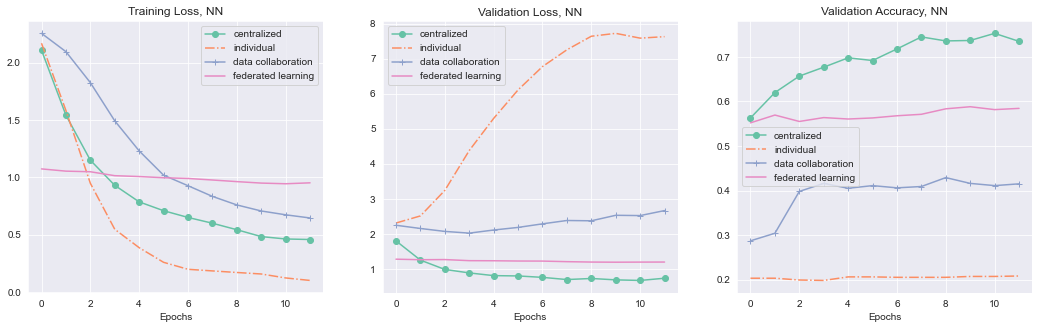

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


ax[0].plot(cntr_history_callback.history['loss'], '-o', label='centralized')
ax[0].plot(ind_history_callback.history['loss'], '-.', label='individual')
ax[0].plot(dc_history_callback.history['loss'], '-+',label='data collaboration')
ax[0].plot(FedTrain, label='federated learning')
# ax[0].plot(DCFedTrain, label='dc federated learning')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[0].set_title('Training Loss, NN')

ax[1].plot(cntr_history_callback.history['val_loss'], '-o',label='centralized')
ax[1].plot(ind_history_callback.history['val_loss'], '-.',label='individual')
ax[1].plot(dc_history_callback.history['val_loss'], '-+', label='data collaboration')
ax[1].plot(FedTest, label='federated learning')
# ax[1].plot(DCFedTest, label='dc federated learning')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[1].set_title('Validation Loss, NN')

ax[2].plot(cntr_history_callback.history['val_sparse_categorical_accuracy'], '-o', label='centralized')
ax[2].plot(ind_history_callback.history['val_sparse_categorical_accuracy'], '-.', label='individual')
ax[2].plot(dc_history_callback.history['val_sparse_categorical_accuracy'], '-+', label='data collaboration')
ax[2].plot(FedAcc, label='federated learning')
# ax[2].plot(DCFedAcc, label='dc federated learning')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[2].set_title('Validation Accuracy, NN')

still its wired to observe that DC is sperier to FL